Uses ideas from paper "Functional, but not anatomical separation of "what" and "when" in prefrontal cortex"

In [1]:
import numpy as np
import pdb
import scipy
from sklearn.decomposition import PCA
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
# loadmat function loads the file into a dictionary
preprocessed = loadmat('MT063_20190910_preprocessed_rasters_v1.mat')
# neurons selected based on the mean response criteria
neurons_with_fr_and_Ca_response = np.where(preprocessed['diff_mean_responsive_cells'][0] == 1)[0]

In [3]:
neurons_with_fr_and_Ca_response

array([ 8, 18, 19, 21, 24, 26, 29, 30, 31, 37, 39, 40, 41, 43, 59, 60, 65,
       69, 88])

(210, 19)
(210, 2)
[0.0833678  0.08040376]


(None, None, None)

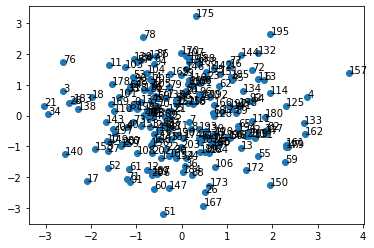

In [4]:
averaged_responses = preprocessed['raster_ordered_poststim'][:,neurons_with_fr_and_Ca_response]
# shuffling responses to ensure no trivial correlation is found
s = np.arange(averaged_responses.shape[0])
np.random.shuffle(s)
shuffled_avg_responses = averaged_responses[s,:]
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(shuffled_avg_responses)

fig, ax = plt.subplots()
ax.scatter(principalComponents[:,0],principalComponents[:,1])
for i in s:
    ax.annotate(str(i), (principalComponents[i,0],principalComponents[i,1]))
    
print(averaged_responses.shape), print(principalComponents.shape), print(pca.explained_variance_ratio_)    

(38010, 106) (38010, 19) (38010, 19) [0.16774854 0.09556866 0.07490903 0.06766585 0.05133771 0.04617189
 0.04292678 0.0418979  0.04107189 0.04015103 0.03982701 0.03916928
 0.03868249 0.03749176 0.03705867 0.03600438 0.0347846  0.03408447
 0.03344806] (19, 19)


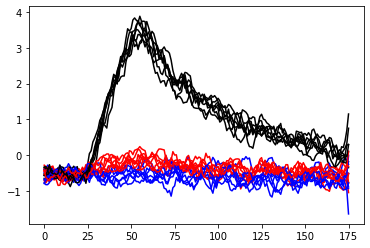

In [5]:
# Finding principal components of responses of all trials together
zscored_responses_all = \
preprocessed['raster_ordered_smoothed_n_by_ct'][:,neurons_with_fr_and_Ca_response]
pca_all = PCA(n_components=zscored_responses_all.shape[1])
pcomponents_all = pca_all.fit_transform(zscored_responses_all)
print(preprocessed['raster_ordered_smoothed_n_by_ct'].shape, \
zscored_responses_all.shape, pcomponents_all.shape, pca_all.explained_variance_ratio_, pca_all.components_.shape)

for i_cond in range(preprocessed['stimInfo']['index'][0][0].shape[0]):
    sum_trials = 0
    for i_trial in range(i_cond*10,(i_cond+1)*10):# range(preprocessed['stimInfo']['order'][0][0].shape[0]):
        #plt.plot(pc_tseries[181*i_trial+5:181*(i_trial+1),1]);
        sum_trials += pcomponents_all[181*i_trial+5:181*(i_trial+1),0]
    if i_cond in [0,3,6,9,12,15,18]:
        color = 'blue'
    elif i_cond in [1,4,7,10,13,16,19]:
        color = 'red'
    else:       
        color = 'black'    
    plt.plot(sum_trials/10, color)    
plt.show()

(3801, 106) (3801, 19) (3801, 19) [0.58210861 0.05738321 0.05339402 0.03736088 0.02552617 0.02414448
 0.0222421  0.02040684 0.01959137 0.01897783 0.01790668 0.01645783
 0.01632412 0.01583074 0.01557525 0.01535454 0.01471841 0.01406705
 0.01262988] (19, 19)


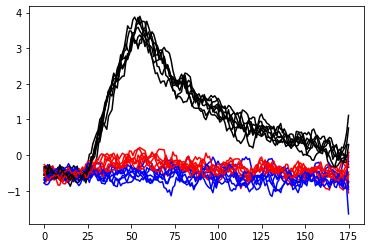

In [6]:
# Finding principal components of trial-averaged responses (we use both signal+noise variance)
zscored_responses_trialaveraged = \
preprocessed['raster_ordered_smoothed_mean_n_by_ct'][:,neurons_with_fr_and_Ca_response]
pca_trialaveraged = PCA(n_components=zscored_responses_trialaveraged.shape[1])
pcomponents_trialaveraged = pca_trialaveraged.fit_transform(zscored_responses_trialaveraged)
print(preprocessed['raster_ordered_smoothed_mean_n_by_ct'].shape, \
zscored_responses_trialaveraged.shape, pcomponents_trialaveraged.shape, \
      pca_trialaveraged.explained_variance_ratio_, pca_trialaveraged.components_.shape)

for i_cond in range(preprocessed['stimInfo']['index'][0][0].shape[0]):
    if i_cond in [0,3,6,9,12,15,18]:
        color = 'blue'
    elif i_cond in [1,4,7,10,13,16,19]:
        color = 'red'
    else:       
        color = 'black'
    plt.plot(pcomponents_trialaveraged[181*i_cond+5:181*(i_cond+1),0],color);
plt.show()

In [7]:
np.mean(pcomponents_trialaveraged,axis=0)

array([-3.73871474e-18,  0.00000000e+00, -1.12161442e-17, -3.73871474e-18,
        7.47742947e-18,  3.73871474e-18,  0.00000000e+00,  8.41210816e-18,
        5.60807211e-18, -2.80403605e-18, -1.86935737e-18,  0.00000000e+00,
       -7.12692497e-18,  1.16834836e-18,  1.63568770e-18, -5.14073276e-18,
        3.27137539e-18, -1.40201803e-18,  3.73871474e-18])

(3801, 19) (38010, 19) (3801, 19)
[0.12758765 0.08762729 0.07067965 0.0639759  0.06252366 0.05946725
 0.05201135 0.05137192 0.05043789 0.04634249 0.04445204 0.04123385
 0.03992509 0.03814108 0.03564881 0.03462114 0.03321066 0.03121168
 0.02953062] 1.6515884766037006 1.3255356457203251


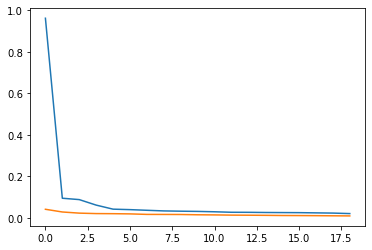

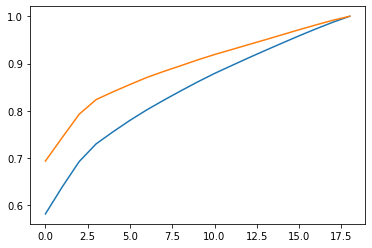

In [8]:
# Finding noise variance and signal variance separately
noise = np.zeros_like(zscored_responses_trialaveraged)
t_length = int(zscored_responses_trialaveraged.shape[0]/21)
for i in range(21):
    noise[i*t_length:(i+1)*t_length,:] = (zscored_responses_all[(i*10+1)*t_length:(i*10+2)*t_length,:] - \
    zscored_responses_all[i*10*t_length:(i*10+1)*t_length,:])/np.sqrt(2*21)
print(noise.shape, zscored_responses_all.shape, zscored_responses_trialaveraged.shape)  
zscored_noise = noise - np.mean(noise,axis=0)

pca_noise = PCA(n_components=zscored_noise.shape[1])
pcomponents_noise = pca_noise.fit_transform(zscored_noise)
signal_variance = pca_trialaveraged.explained_variance_ - pca_noise.explained_variance_
print(pca_noise.explained_variance_ratio_, np.sum(pca_trialaveraged.explained_variance_), np.sum(signal_variance))
plt.plot(pca_trialaveraged.explained_variance_)
plt.plot(pca_noise.explained_variance_); plt.show()
plt.plot(np.cumsum(pca_trialaveraged.explained_variance_)/np.sum(pca_trialaveraged.explained_variance_))
plt.plot(np.cumsum(signal_variance)/np.sum(signal_variance))

(543, 19) (1267, 19) (19, 19) (19, 19)
[-7.37169801e-01  4.02784500e-02  1.74982095e-02 -5.62143715e-03
  1.37526338e-02  1.05374021e-02 -1.12533799e-04  8.58880462e-03
  7.44124958e-03  7.04451236e-03  5.81495785e-03  5.57948426e-03
  5.47252171e-03  4.77534585e-03  2.43990597e-03  2.57601157e-03
  3.05010796e-03  3.41239666e-03  3.66613998e-03] (3801, 19)


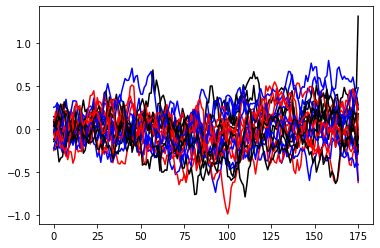

In [14]:
# DOC
pca_light = np.zeros((t_length*3,pcomponents_trialaveraged.shape[1]))
pca_sound = np.zeros((t_length*7,pcomponents_trialaveraged.shape[1]))

for il in range(7):
    pca_light[:t_length,:] += pcomponents_trialaveraged[t_length*3*il:t_length*(3*il+1),:]/7
    pca_light[t_length:2*t_length,:] += pcomponents_trialaveraged[t_length*(3*il+1):t_length*(3*il+2),:]/7
    pca_light[2*t_length:3*t_length,:] += pcomponents_trialaveraged[t_length*(3*il+2):t_length*(3*il+3),:]/7

for iso in range(3):    
    pca_sound[:t_length,:] += pcomponents_trialaveraged[t_length*(iso):t_length*(iso+1),:]/3
    pca_sound[t_length:2*t_length,:] += pcomponents_trialaveraged[t_length*(3+iso):t_length*(3+iso+1),:]/3
    pca_sound[2*t_length:3*t_length,:] += pcomponents_trialaveraged[t_length*(6+iso):t_length*(6+iso+1),:]/3    
    pca_sound[3*t_length:4*t_length,:] += pcomponents_trialaveraged[t_length*(9+iso):t_length*(9+iso+1),:]/3 
    pca_sound[4*t_length:5*t_length,:] += pcomponents_trialaveraged[t_length*(12+iso):t_length*(12+iso+1),:]/3 
    pca_sound[5*t_length:6*t_length,:] += pcomponents_trialaveraged[t_length*(15+iso):t_length*(15+iso+1),:]/3 
    pca_sound[6*t_length:7*t_length,:] += pcomponents_trialaveraged[t_length*(18+iso):t_length*(18+iso+1),:]/3 

cov_light = np.cov(np.transpose(pca_light))
cov_sound = np.cov(np.transpose(pca_sound))
cov_diff = -cov_light +cov_sound
cov_eigenvalues, cov_eigenvectors = np.linalg.eig(cov_diff)
new_projection = np.dot(pcomponents_trialaveraged,cov_eigenvectors)

print(pca_light.shape, pca_sound.shape, cov_light.shape, cov_sound.shape)
print(cov_eigenvalues, new_projection.shape)  

for i_cond in range(preprocessed['stimInfo']['index'][0][0].shape[0]):
    if i_cond in [0,3,6,9,12,15,18]:
        color = 'blue'
    elif i_cond in [1,4,7,10,13,16,19]:
        color = 'red'
    else:       
        color = 'black'
    plt.plot(new_projection[181*i_cond+5:181*(i_cond+1),4],color);
plt.show()


In [ ]:
# Responses of only vip / som cells

isredcell = preprocessed['RedCells']['isCell_red']
redcellIdxs = np.where(isredcell[0][0] == 1)[0]
redcellIdxs

# vip_responses_tseries = preprocessed['raster_ordered_mean_n_by_ct'][:,redcellIdxs]
# vip_pc_tseries = pca.transform(vip_responses_tseries)
# vip_responses_tseries.shape, vip_pc_tseries.shape, pca.explained_variance_ratio_

In [ ]:
# pca_dim = np.expand_dims(np.where(abs(pca.components_)>0.0999)[0],axis=1)
# neuron = np.expand_dims(np.where(abs(pca.components_)>0.0999)[1],axis=1)
# np.concatenate((pca_dim,neuron),axis=1)
neurons_with_fr_and_Ca_response[np.where(abs(pca.components_[1,:])>0.0999)[0]]

In [ ]:
vip_responses_tseries.shape

In [ ]:
for i in [14]:# range(preprocessed['stimInfo']['index'][0][0].shape[0]):
    plt.plot(vip_pc_tseries[181*i:181*(i+1),0],vip_pc_tseries[181*i:181*(i+1),1]); plt.show()
    plt.plot(vip_pc_tseries[181*i:181*(i+1),0],vip_pc_tseries[181*i:181*(i+1),2]); plt.show()
    plt.plot(vip_pc_tseries[181*i:181*(i+1),1],vip_pc_tseries[181*i:181*(i+1),2]); plt.show()
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(vip_pc_tseries[181*i:181*(i+1),0]); ax2.plot(vip_pc_tseries[181*i:181*(i+1),1])
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(vip_pc_tseries[181*i:181*(i+1),2]); ax2.plot(vip_pc_tseries[181*i:181*(i+1),3])
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(vip_pc_tseries[181*i:181*(i+1),4])
    plt.show() 